Found 12 files belonging to 1 classes.
Using 10 files for training.
Found 12 files belonging to 1 classes.
Using 2 files for validation.
Found 12 files belonging to 1 classes.
Using 10 files for training.
Found 12 files belonging to 1 classes.
Using 2 files for validation.
Finished loading data


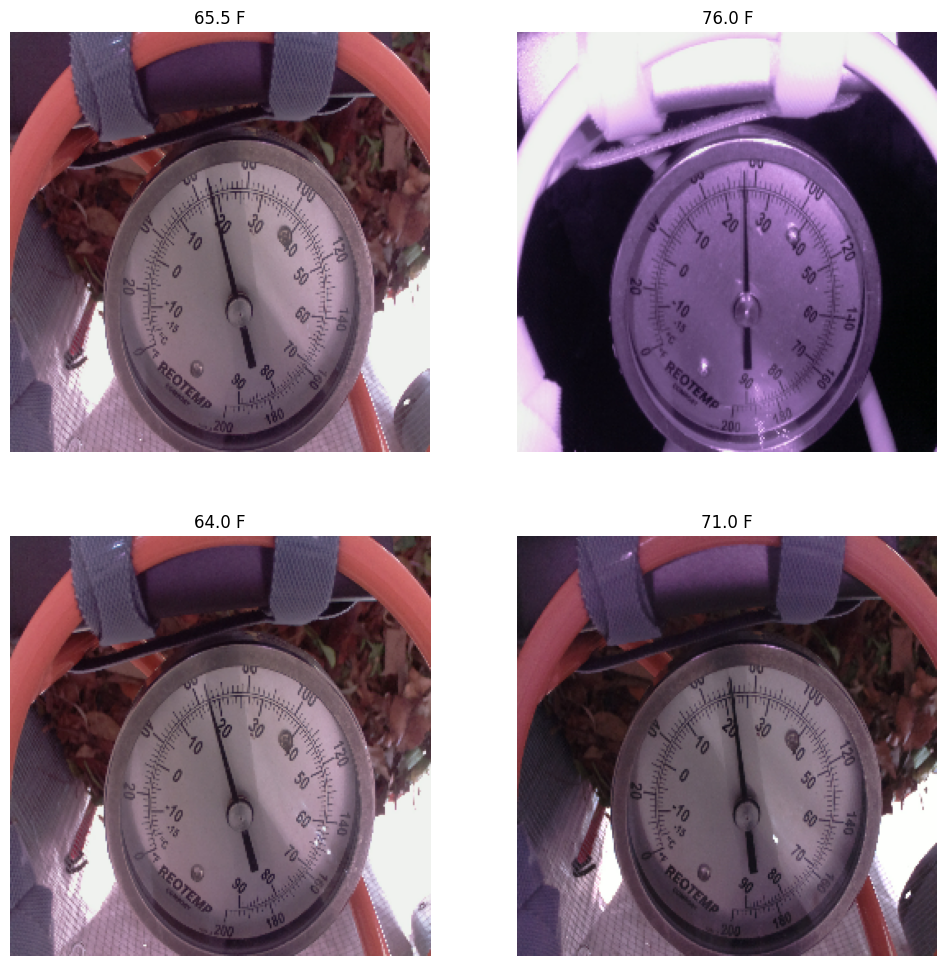

In [61]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

TEST_SPLIT = 0.2
SEED = 42

IMAGES_PATH = "/home/peter/Pictures/thermometer-photos/flat/"

def normalize_image(image):
    # standardize
    image = image / 255.
    # convert to 1D array
    image = image.reshape(-1).T
    return image

def load_dataset():
    x_train = tf.keras.utils.image_dataset_from_directory(
        IMAGES_PATH,
        labels=None,
        label_mode=None,
        seed=SEED,
        validation_split=TEST_SPLIT,
        subset="training",
    )
    x_test = tf.keras.utils.image_dataset_from_directory(
        IMAGES_PATH,
        labels=None,
        label_mode=None,
        seed=SEED,
        validation_split=TEST_SPLIT,
        subset="validation",
    )
    y_train = tf.keras.utils.text_dataset_from_directory(
        IMAGES_PATH,
        labels=None,
        label_mode=None,
        seed=SEED,
        validation_split=TEST_SPLIT,
        subset="training",
    )
    y_test = tf.keras.utils.text_dataset_from_directory(
        IMAGES_PATH,
        labels=None,
        label_mode=None,
        seed=SEED,
        validation_split=TEST_SPLIT,
        subset="validation",
    )
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load_dataset()

print("Finished loading data")

plt.figure(figsize=(12, 12))
for images, labels in tf.data.Dataset.zip((x_train.take(1), y_train.take(1))):
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{float(labels[i].numpy())} F")
        plt.axis("off")
